In [1]:
import os
import zipfile
import pickle
import h5py
import cv2
from google.colab.patches import cv2_imshow
%matplotlib inline

In [2]:
import scipy as sp
import numpy as np
import pandas as pd
import PIL
import scipy.ndimage as spi
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1 for meningioma, 2 for glioma, 3 for pituitary tumor

In [4]:
image_size = (256, 256)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/dataset/BrainTumor",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/dataset/BrainTumor",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 3064 files belonging to 3 classes.
Using 2452 files for training.
Found 3064 files belonging to 3 classes.
Using 612 files for validation.


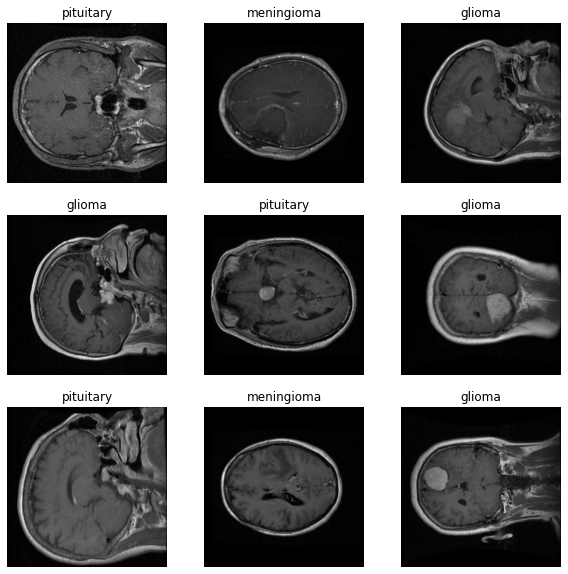

In [5]:
import matplotlib.pyplot as plt
        
class_names = [ 'meningioma','glioma', 'pituitary']
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

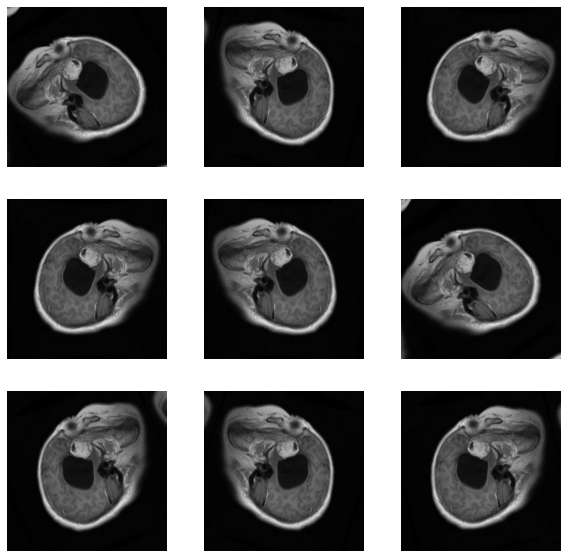

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [8]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [9]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [10]:
train_ds = augmented_train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)
test_ds = test_ds.prefetch(buffer_size=32)

In [12]:

IMG_SHAPE = image_size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [13]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 8, 1280)


In [14]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [16]:
prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [17]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [18]:
inputs = tf.keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1280,activation='relu')(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

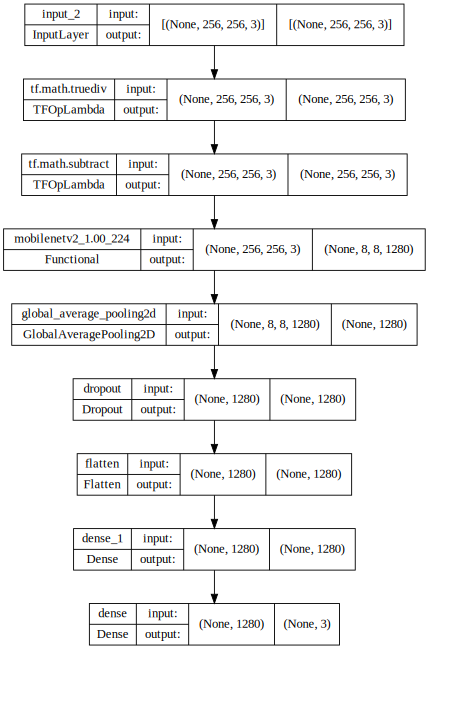

In [19]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [21]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [22]:
len(model.trainable_variables)

4

In [23]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

16/16 [==============================] - 49s 1s/step - loss: 1.3549 - accuracy: 0.2769
initial loss: 1.35
initial accuracy: 0.28


In [24]:
history = model.fit(train_ds,
                         epochs=initial_epochs,
                         validation_data=val_ds,
                         shuffle=True
                        )

Epoch 1/10
77/77 [==============================] - 177s 2s/step - loss: 0.6172 - accuracy: 0.7390 - val_loss: 0.4445 - val_accuracy: 0.8140
Epoch 2/10
77/77 [==============================] - 30s 387ms/step - loss: 0.3712 - accuracy: 0.8491 - val_loss: 0.3248 - val_accuracy: 0.8802
Epoch 3/10
77/77 [==============================] - 31s 400ms/step - loss: 0.3389 - accuracy: 0.8662 - val_loss: 0.2927 - val_accuracy: 0.8926
Epoch 4/10
77/77 [==============================] - 30s 387ms/step - loss: 0.3176 - accuracy: 0.8736 - val_loss: 0.2915 - val_accuracy: 0.8946
Epoch 5/10
77/77 [==============================] - 30s 387ms/step - loss: 0.2919 - accuracy: 0.8887 - val_loss: 0.2689 - val_accuracy: 0.9029
Epoch 6/10
77/77 [==============================] - 31s 394ms/step - loss: 0.2751 - accuracy: 0.8895 - val_loss: 0.3088 - val_accuracy: 0.8781
Epoch 7/10
77/77 [==============================] - 30s 385ms/step - loss: 0.2788 - accuracy: 0.8948 - val_loss: 0.2553 - val_accuracy: 0.9174
E

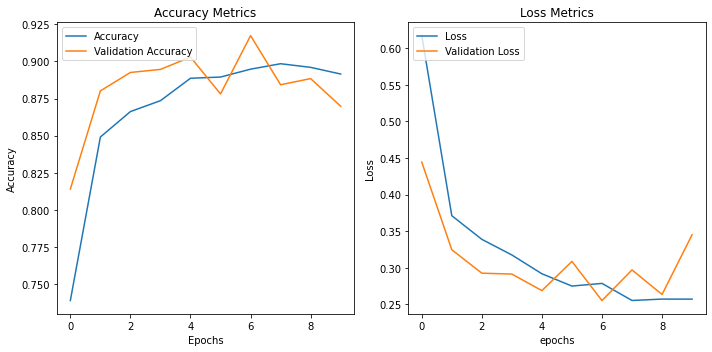

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = 10
epochs_range = range(0, epochs)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax1 = axes[0]
ax2 = axes[1]
ax1 = plt.subplot(1,2,1)
      
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracy Metrics")
ax1.plot(epochs_range, acc)
ax1.plot(epochs_range, val_acc)
ax1.legend(["Accuracy", "Validation Accuracy"], loc ="upper left")
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = 10
epochs_range = range(0, epochs)

ax2.set_xlabel("epochs")
ax2.set_ylabel("Loss")
ax2.set_title("Loss Metrics")
ax2.plot(epochs_range, loss)
ax2.plot(epochs_range, val_loss)
ax2.legend(["Loss", "Validation Loss"], loc ="upper left")

fig.tight_layout()

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [27]:
img = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/Colab Notebooks/dataset/yes/y1002.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
predictions = model.predict(img_array)
score = predictions[0]
print(score)





[-0.7226801 -1.7256685  3.036912 ]


In [28]:
%cd /content/drive/MyDrive/Colab Notebooks/
model.save('model_final_multi-classification.h5')
    

/content/drive/MyDrive/Colab Notebooks


In [29]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

4/4 [==============================] - 1s 136ms/step - loss: 0.2770 - accuracy: 0.8984
Test accuracy : 0.8984375


In [30]:
labels_entire = []
pred_entire = []
for image_batch,label_batch in test_ds.as_numpy_iterator():
    prediction = model.predict_on_batch(image_batch).flatten()

    # Apply a sigmoid since our model returns logits
    predictions = tf.nn.sigmoid(prediction).numpy()

    n = 0
    predict = []
    while n<=(predictions.shape[0]-3):
        pred = np.argmax(predictions[n:n+3]) #Returns the index of the largest element in the selected subarray
        n+=3
        pred_entire.append(pred)
    for el in label_batch:
        labels_entire.append(el)
pred_entire = np.array(pred_entire)
labels_entire = np.array(labels_entire)
print(pred_entire)
print(labels_entire)

[2 2 2 2 2 0 0 0 0 1 1 2 1 0 0 1 2 2 2 0 0 2 0 1 1 2 1 1 2 0 2 1 2 1 1 1 1
 2 2 2 0 0 2 0 1 2 1 0 1 2 0 1 1 2 2 2 1 0 0 0 2 2 1 2 0 1 1 0 1 1 0 0 0 0
 2 0 2 1 1 2 2 2 2 0 0 0 0 1 1 1 0 0 0 0 2 0 2 2 1 0 2 0 0 0 2 2 2 0 2 2 0
 1 2 2 0 1 1 0 1 2 0 0 0 0 1 2 1 2]
[2 2 2 2 2 0 0 0 0 1 1 2 1 0 0 1 2 2 2 0 0 2 0 1 1 2 1 1 2 0 2 1 2 1 0 0 0
 2 2 2 0 0 2 0 1 2 1 0 1 2 0 0 1 2 2 2 0 0 0 0 2 2 1 2 0 1 1 0 1 1 0 0 0 0
 2 0 2 0 0 2 2 2 2 0 0 0 0 1 1 0 0 0 0 0 2 0 2 2 1 0 2 0 0 0 2 2 2 0 2 2 0
 1 2 2 0 1 1 0 1 2 0 0 0 0 0 2 0 2]


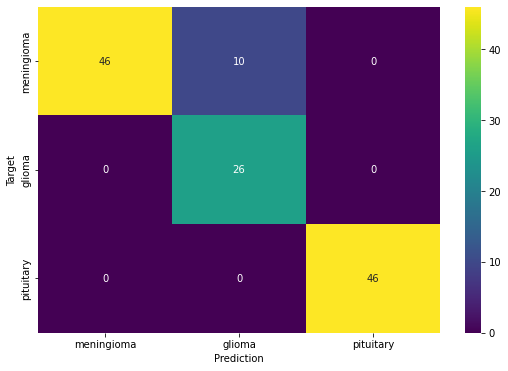

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline

arr = confusion_matrix(labels_entire, pred_entire)
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='viridis')
plt.xlabel("Prediction")
plt.ylabel("Target")
plt.show()

In [32]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(labels_entire, pred_entire, pos_label=2)
metrics.auc(fpr, tpr)

1.0